In [ ]:
#os.chdir('/content/drive/MyDrive/Escuela/Doctorado/Projects/ConvNext/ConvNext_V2')

In [1]:
!nvidia-smi

Mon Oct  6 14:24:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   44C    P3             41W /  220W |      15MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_allocated()  
torch.cuda.memory_reserved()  
import zipfile
import os
import nibabel as nib
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torch.utils.data import random_split
import wandb
from torchvision import models
import torch.optim as optim

# DataLoader

In [3]:
%run src/ConvNext_models.ipynb
%run src/metrics.ipynb
%run src/hg_lossfunctions.ipynb
%run src/trainer.ipynb
%run src/BratsDataloader.ipynb
%run src/Optimizer.ipynb

Output: torch.Size([2, 1, 512, 512])
Path BrATS2021: BrATS2021/
Path BrATS2023: BrATS2023/


In [4]:
base_path ="../datasets/BRATS2024/"#"/content/drive/MyDrive/datasets/BrATS2023/BrATS2023/"#"BraTS2021_Training_Data" #"BrATS2023" #"/content/drive/MyDrive/datasets/BrATS2023/BrATS2023"

# Transformación opcional, si necesitas redimensionar o normalizar
transform = transforms.Compose([
    transforms.Resize((512, 512))  # Cambia al tamaño deseado
    #transforms.Normalize(mean=[0.5], std=[0.5]) # For -1 a 1
])

# Crear el dataset y el DataLoader
dataset = BRATSDataset_2(base_path, img_transform=transform, mask_transform = transform)

train_size = int(0.7 * len(dataset))  # 70% para entrenamiento
val_size   = int(0.15 * len(dataset))   # 15% para validación
test_size  = len(dataset) - train_size - val_size  # 15% para prueba

# Dividir el dataset en entrenamiento, validación y prueba
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Crear los DataLoaders para cada conjunto
BATCH_SIZE = 6
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size   = BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size  = BATCH_SIZE, shuffle=False)
print(np.shape(train_loader))
for img, mask in train_loader:
    print(np.shape(img))
    print(np.shape(mask))
    break
# IN testing pahse
def get_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

# 2. Obtener el tamaño en memoria del modelo (sin necesidad de guardarlo en archivo)
def get_model_memory_size(model):
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    return param_size
def get_model_flops(model, input_size=(1, 512, 512), device='cuda'):
    model = model.to(device)
    model.eval()
    
    total_flops = 0
    total_params = sum(p.numel() for p in model.parameters())

()
torch.Size([6, 1, 512, 512])
torch.Size([6, 1, 512, 512])


------------------------ Model Name: ConvNeXtSegmentationMF
------------------------ OPtimizer Name: AdamW
------------------------ Loss Name: BCE
None


wandb: Currently logged in as: fd-hernandezgutierrez (hgfernandod) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch [1/100] - Train Loss: 0.2626, Val Loss: 0.1772
New best model saved with Val Loss: 0.1772
Epoch [2/100] - Train Loss: 0.1481, Val Loss: 0.1829
Epoch [3/100] - Train Loss: 0.1640, Val Loss: 0.1328
New best model saved with Val Loss: 0.1328
Epoch [4/100] - Train Loss: 0.1219, Val Loss: 0.0920
New best model saved with Val Loss: 0.0920
Epoch [5/100] - Train Loss: 0.1148, Val Loss: 0.1065
Epoch [6/100] - Train Loss: 0.1003, Val Loss: 0.1034
Epoch [7/100] - Train Loss: 0.0974, Val Loss: 0.0810
New best model saved with Val Loss: 0.0810
Epoch [8/100] - Train Loss: 0.0810, Val Loss: 0.0971
Epoch [9/100] - Train Loss: 0.0882, Val Loss: 0.0665
New best model saved with Val Loss: 0.0665
Epoch [10/100] - Train Loss: 0.0660, Val Loss: 0.0861
Epoch [11/100] - Train Loss: 0.0749, Val Loss: 0.0449
New best model saved with Val Loss: 0.0449
Epoch [12/100] - Train Loss: 0.0601, Val Loss: 0.0461
Epoch [13/100] - Train Loss: 0.0574, Val Loss: 0.0465
Epoch [14/100] - Train Loss: 0.0511, Val Loss: 0.

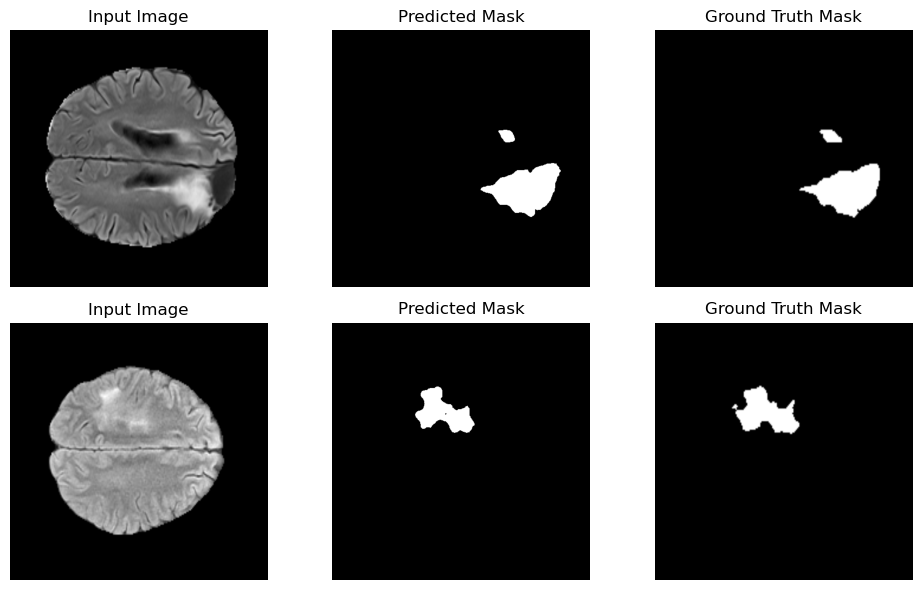

{'Dice Coefficient': 0.903032648563385, 'IoU Score': 0.8250269889831543, 'Precision': 0.9515493035316467, 'Sensitivity (Recall)': 0.862092936038971, 'Specificity': 0.9975664734840393, 'Accuracy': 0.9839793086051941, 'F1-Score': 0.9030326425092262, 'Hausdorff': 46.779915770936654, 'FPS': 60.04050462021284, 'ms_per_img': 16.655422973632813, 'avg_fps': np.float64(59.86790510771166), 'std_fps': np.float64(0.23841591106848103), 'avg_latency': np.float64(16.70370585123698), 'std_latency': np.float64(0.06659318339130774)}
{'FPS': 60.04050462021284, 'ms_per_img': 16.655422973632813, 'avg_fps': np.float64(59.86790510771166), 'std_fps': np.float64(0.23841591106848103), 'avg_latency': np.float64(16.70370585123698), 'std_latency': np.float64(0.06659318339130774)}
{'Dice Coefficient': 0.903032648563385, 'IoU Score': 0.8250269889831543, 'Precision': 0.9515493035316467, 'Sensitivity (Recall)': 0.862092936038971, 'Specificity': 0.9975664734840393, 'Accuracy': 0.9839793086051941, 'F1-Score': 0.90303264

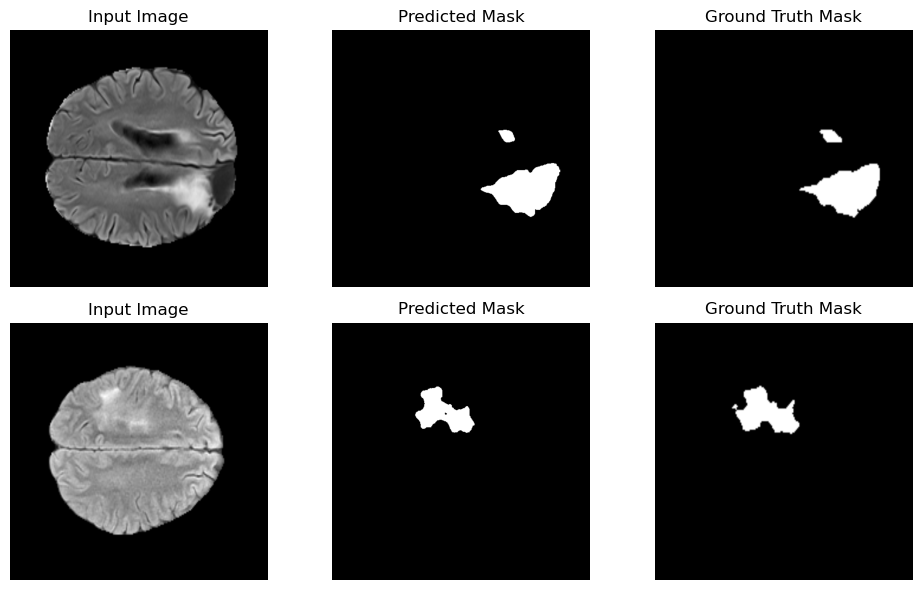

{'Dice Coefficient': 0.9017058730125427, 'IoU Score': 0.8228523969650269, 'Precision': 0.9543229818344117, 'Sensitivity (Recall)': 0.8574396252632142, 'Specificity': 0.9977208495140075, 'Accuracy': 0.9838844537734985, 'F1-Score': 0.9017059211706788, 'Hausdorff': 46.91275029812496, 'FPS': 59.662499393461, 'ms_per_img': 16.76094716389974, 'avg_fps': np.float64(59.73606282235128), 'std_fps': np.float64(0.1835186173433362), 'avg_latency': np.float64(16.740464731852214), 'std_latency': np.float64(0.05150935792195414)}
{'FPS': 59.662499393461, 'ms_per_img': 16.76094716389974, 'avg_fps': np.float64(59.73606282235128), 'std_fps': np.float64(0.1835186173433362), 'avg_latency': np.float64(16.740464731852214), 'std_latency': np.float64(0.05150935792195414)}
{'Dice Coefficient': 0.9017058730125427, 'IoU Score': 0.8228523969650269, 'Precision': 0.9543229818344117, 'Sensitivity (Recall)': 0.8574396252632142, 'Specificity': 0.9977208495140075, 'Accuracy': 0.9838844537734985, 'F1-Score': 0.90170592117

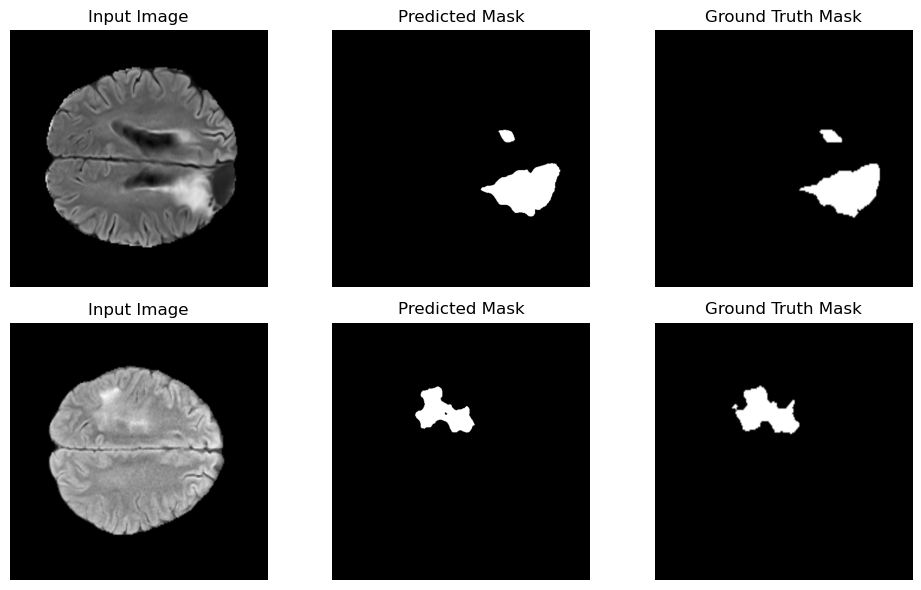

{'Dice Coefficient': 0.9002733111381531, 'IoU Score': 0.8205138444900513, 'Precision': 0.9569742798805236, 'Sensitivity (Recall)': 0.8527402281761169, 'Specificity': 0.9978667855262756, 'Accuracy': 0.9837804317474366, 'F1-Score': 0.9002733154722588, 'Hausdorff': 46.849634982008624, 'FPS': 60.47725687801603, 'ms_per_img': 16.53514149983724, 'avg_fps': np.float64(59.76572190860836), 'std_fps': np.float64(0.23348841126319517), 'avg_latency': np.float64(16.732255350748694), 'std_latency': np.float64(0.0656145937818673)}
{'FPS': 60.47725687801603, 'ms_per_img': 16.53514149983724, 'avg_fps': np.float64(59.76572190860836), 'std_fps': np.float64(0.23348841126319517), 'avg_latency': np.float64(16.732255350748694), 'std_latency': np.float64(0.0656145937818673)}
{'Dice Coefficient': 0.9002733111381531, 'IoU Score': 0.8205138444900513, 'Precision': 0.9569742798805236, 'Sensitivity (Recall)': 0.8527402281761169, 'Specificity': 0.9978667855262756, 'Accuracy': 0.9837804317474366, 'F1-Score': 0.900273

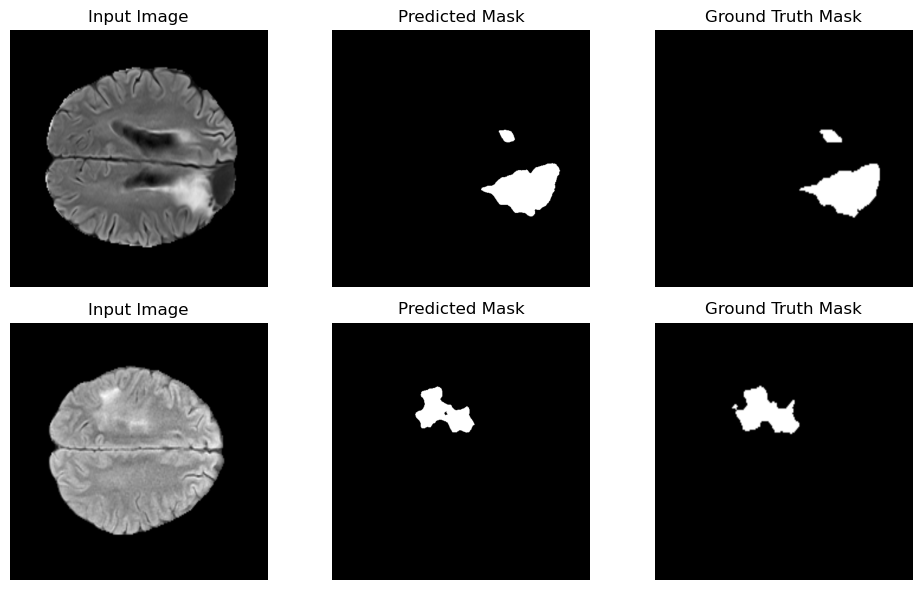

{'Dice Coefficient': 0.8985720992088317, 'IoU Score': 0.8177355885505676, 'Precision': 0.9595299005508423, 'Sensitivity (Recall)': 0.847710108757019, 'Specificity': 0.9980065107345581, 'Accuracy': 0.9836597800254822, 'F1-Score': 0.8985721056046636, 'Hausdorff': 46.86134482196199, 'FPS': 60.119126430637856, 'ms_per_img': 16.633641560872395, 'avg_fps': np.float64(59.80105128329872), 'std_fps': np.float64(0.37029003632113133), 'avg_latency': np.float64(16.72275568644206), 'std_latency': np.float64(0.10362483775988317)}
{'FPS': 60.119126430637856, 'ms_per_img': 16.633641560872395, 'avg_fps': np.float64(59.80105128329872), 'std_fps': np.float64(0.37029003632113133), 'avg_latency': np.float64(16.72275568644206), 'std_latency': np.float64(0.10362483775988317)}
{'Dice Coefficient': 0.8985720992088317, 'IoU Score': 0.8177355885505676, 'Precision': 0.9595299005508423, 'Sensitivity (Recall)': 0.847710108757019, 'Specificity': 0.9980065107345581, 'Accuracy': 0.9836597800254822, 'F1-Score': 0.89857

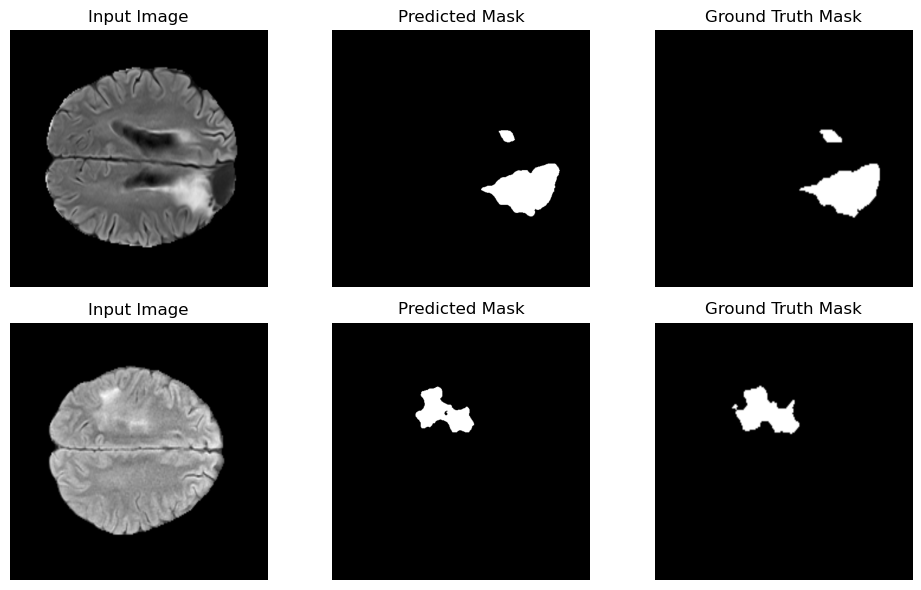

{'Dice Coefficient': 0.8966897130012512, 'IoU Score': 0.8146671772003173, 'Precision': 0.9620235323905945, 'Sensitivity (Recall)': 0.8424723148345947, 'Specificity': 0.9981436967849732, 'Accuracy': 0.9835287928581238, 'F1-Score': 0.8966896916131993, 'Hausdorff': 46.76510168973507, 'FPS': 60.369095633744855, 'ms_per_img': 16.564766947428385, 'avg_fps': np.float64(59.560464728134605), 'std_fps': np.float64(0.3863112375604837), 'avg_latency': np.float64(16.79036926269531), 'std_latency': np.float64(0.10922901855199568)}
{'FPS': 60.369095633744855, 'ms_per_img': 16.564766947428385, 'avg_fps': np.float64(59.560464728134605), 'std_fps': np.float64(0.3863112375604837), 'avg_latency': np.float64(16.79036926269531), 'std_latency': np.float64(0.10922901855199568)}
{'Dice Coefficient': 0.8966897130012512, 'IoU Score': 0.8146671772003173, 'Precision': 0.9620235323905945, 'Sensitivity (Recall)': 0.8424723148345947, 'Specificity': 0.9981436967849732, 'Accuracy': 0.9835287928581238, 'F1-Score': 0.896

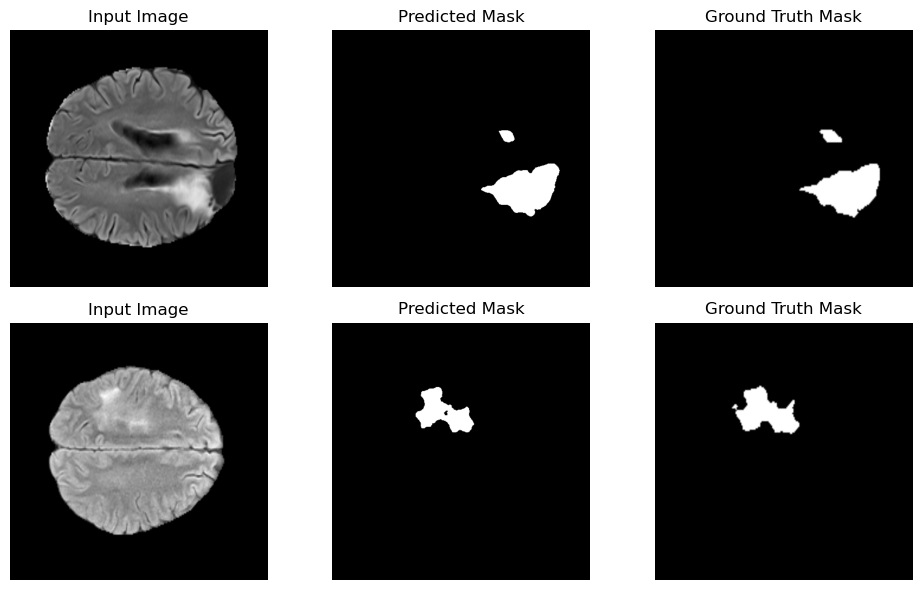

{'Dice Coefficient': 0.8947265028953553, 'IoU Score': 0.8114904522895813, 'Precision': 0.9643253803253173, 'Sensitivity (Recall)': 0.8372992753982544, 'Specificity': 0.9982687473297119, 'Accuracy': 0.9833901882171631, 'F1-Score': 0.8947265062671205, 'Hausdorff': 46.7819655716988, 'FPS': 60.27995280878817, 'ms_per_img': 16.58926315307617, 'avg_fps': np.float64(59.69561475367269), 'std_fps': np.float64(0.3381786550020278), 'avg_latency': np.float64(16.752185719807944), 'std_latency': np.float64(0.09470040601164517)}
{'FPS': 60.27995280878817, 'ms_per_img': 16.58926315307617, 'avg_fps': np.float64(59.69561475367269), 'std_fps': np.float64(0.3381786550020278), 'avg_latency': np.float64(16.752185719807944), 'std_latency': np.float64(0.09470040601164517)}
{'Dice Coefficient': 0.8947265028953553, 'IoU Score': 0.8114904522895813, 'Precision': 0.9643253803253173, 'Sensitivity (Recall)': 0.8372992753982544, 'Specificity': 0.9982687473297119, 'Accuracy': 0.9833901882171631, 'F1-Score': 0.89472650

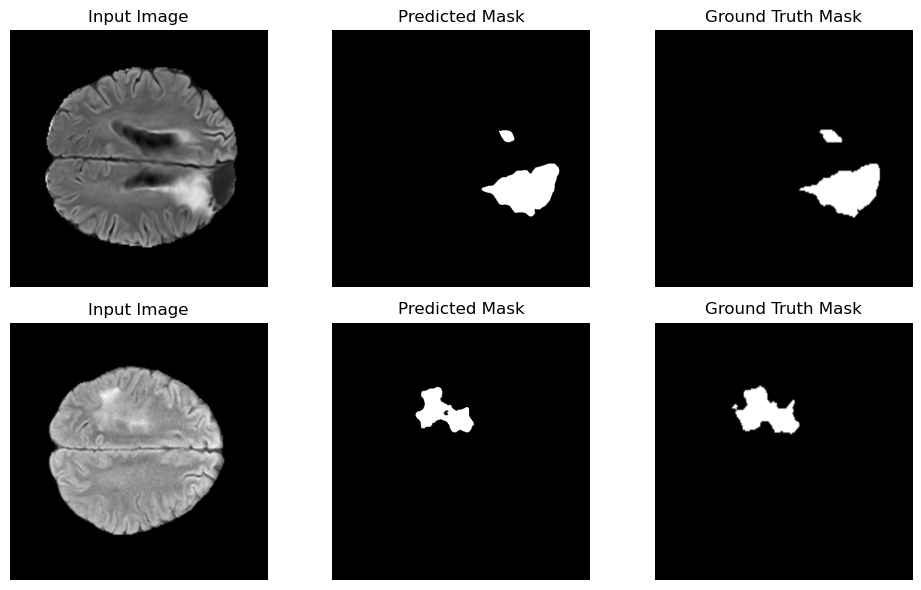

{'Dice Coefficient': 0.8926013112068176, 'IoU Score': 0.8080620050430298, 'Precision': 0.9666003942489624, 'Sensitivity (Recall)': 0.8319223642349243, 'Specificity': 0.9983901262283326, 'Accuracy': 0.9832438349723815, 'F1-Score': 0.8926013397928232, 'Hausdorff': 46.62100529875033, 'FPS': 59.411226370210464, 'ms_per_img': 16.83183568318685, 'avg_fps': np.float64(59.967248088568816), 'std_fps': np.float64(0.29600340901112654), 'avg_latency': np.float64(16.676177419026693), 'std_latency': np.float64(0.08266366004817303)}
{'FPS': 59.411226370210464, 'ms_per_img': 16.83183568318685, 'avg_fps': np.float64(59.967248088568816), 'std_fps': np.float64(0.29600340901112654), 'avg_latency': np.float64(16.676177419026693), 'std_latency': np.float64(0.08266366004817303)}
{'Dice Coefficient': 0.8926013112068176, 'IoU Score': 0.8080620050430298, 'Precision': 0.9666003942489624, 'Sensitivity (Recall)': 0.8319223642349243, 'Specificity': 0.9983901262283326, 'Accuracy': 0.9832438349723815, 'F1-Score': 0.8

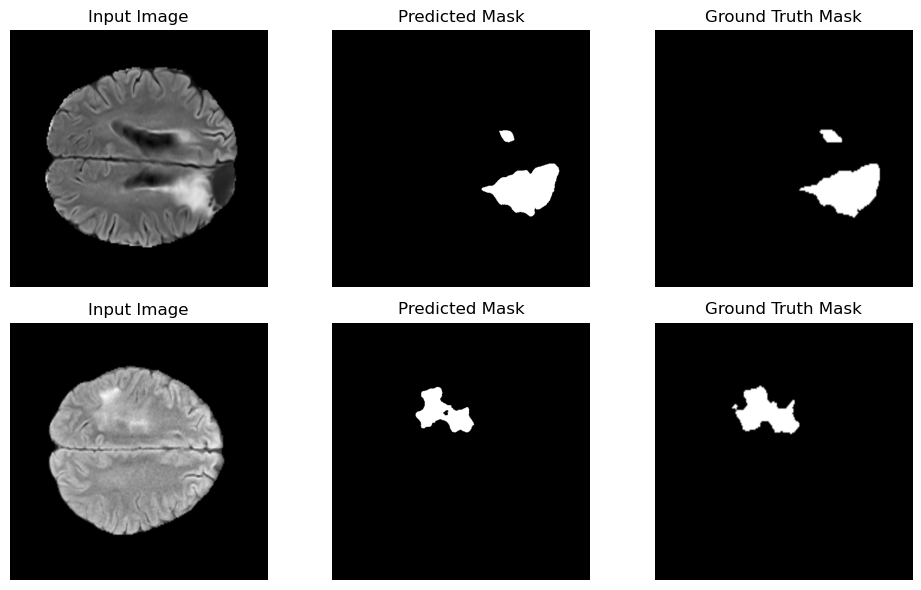

{'Dice Coefficient': 0.8902745723724366, 'IoU Score': 0.8043192267417908, 'Precision': 0.9687229752540588, 'Sensitivity (Recall)': 0.8263544559478759, 'Specificity': 0.9985031843185425, 'Accuracy': 0.9830870628356934, 'F1-Score': 0.890274599957103, 'Hausdorff': 46.57341125108909, 'FPS': 59.500466095760835, 'ms_per_img': 16.806591033935547, 'avg_fps': np.float64(59.92732429152378), 'std_fps': np.float64(0.34854625835209213), 'avg_latency': np.float64(16.68744206746419), 'std_latency': np.float64(0.09683861185316721)}
{'FPS': 59.500466095760835, 'ms_per_img': 16.806591033935547, 'avg_fps': np.float64(59.92732429152378), 'std_fps': np.float64(0.34854625835209213), 'avg_latency': np.float64(16.68744206746419), 'std_latency': np.float64(0.09683861185316721)}
{'Dice Coefficient': 0.8902745723724366, 'IoU Score': 0.8043192267417908, 'Precision': 0.9687229752540588, 'Sensitivity (Recall)': 0.8263544559478759, 'Specificity': 0.9985031843185425, 'Accuracy': 0.9830870628356934, 'F1-Score': 0.8902

Accuracy,██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
Dice Coefficient,██▇▇▆▆▆▆▅▅▃▃▂▂▁▁
F1-Score,██▇▇▆▆▆▆▅▅▃▃▂▂▁▁
FPS,▅▅▃▃██▆▆▇▇▇▇▁▁▂▂
Hausdorff,▅▅██▇▇▇▇▅▅▅▅▂▂▁▁
IoU Score,██▇▇▆▆▆▆▄▄▃▃▂▂▁▁
Precision,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
Sensitivity (Recall),██▇▇▆▆▅▅▄▄▃▃▂▂▁▁
Specificity,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
avg_fps,▆▆▄▄▅▅▅▅▁▁▃▃██▇▇
+7,...


In [6]:
from matplotlib.backends.backend_pdf import PdfPages

device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes     = 1  # Ejemplo: edema, realce, necrosis, etc.
ConvNext_models = {  #'HyperNetSegmentation'    : HyperNetSegmentation,
                     'ConvNeXtSegmentationMF'  : ConvNeXtSegmentationMF, # dió IoU: 0.8
                     #'ConvNeXtUNet'            : ConvNeXtUNet,
                     #'ConvNeXtUNet_B'          : ConvNeXtUNet_B,
                     #ConvNext_Base'           : ConvNeXtSegmentation
                     #'ConvNeXtSegmentationRA'  : ConvNeXtSegmentationRA #use highg resources
}

optimizers      =  { 
                     #'Adam'     : lambda model: optim.Adam(model.parameters(), lr = 0.001),
                     'AdamW'    : lambda model: optim.AdamW(model.parameters(), lr=0.001),
                     #'CRTAdamW' : lambda model:CRTAdamW(model.parameters(), lr = 0.001),
                  }

functions_losses = { #'BCEDiceLoss': BCEDiceLoss(),
                     #'DSC': DiceLoss(),
                     'BCE':nn.BCEWithLogitsLoss()
                   }

for model_name, model_class in ConvNext_models.items():      # Models 
    for optimizer_name, optimizer_class in optimizers.items(): # Optimizers
        for losses_name, losses_class in functions_losses.items(): # Losses
            print('------------------------ Model Name:', model_name)
            print('------------------------ OPtimizer Name:', optimizer_name)
            print('------------------------ Loss Name:', losses_name)

            if model_name =='ConvNeXtUNet' or  model_name == 'ConvNeXtRAUNet' or model_name == 'ConvNeXtMFRAUNet':
                model = model_class(num_classes, backbone_type='base')
            else:
                model       =  model_class(num_classes)   #ConvNeXtSegmentation(num_classes)
            
            model       = model.to(device)  # Si estás usando una GPU
            criterion   =  losses_class #nn.BCEWithLogitsLoss()  # CrossEntropyLoss()
            optimizer   =  optimizer_class(model)# CRTAdamW(model.parameters(), lr = 0.001)#optim.AdamW(model.parameters(), lr=0.001)# CRTAdamW
            num_epochs  = 100
        
            Metrics = []
            Conv_Next_trainer = UNetTrainer(
                    model        = model,
                    device       = device,
                    optimizer    = optimizer,
                    criterion    = criterion,
                    train_loader = train_loader,
                    val_loader   = val_loader,
                    test_loader  = test_loader,
                    epochs       = num_epochs,
                    filename_model = model_name + '.pth'
                )
            total_params      = get_model_parameters(model)
            model_memory_size = get_model_memory_size(model)/ (1024 ** 2)
            FLOps             = get_model_flops(model)
            print(FLOps)
            wandb.init(project="ConvNext_V2_RTX4070Super_Brats2024_", config={
                'Dataset'       : base_path, 
                'device'        : device,
                'model name'    : model_name,
                'epochs'        : num_epochs,
                'batch size'    : BATCH_SIZE,
                'loss_function' : losses_name, #criterion,
                'optimizer'     : optimizer_name,#optimizer,
                'total params'  :total_params,
                'Model Size (MB)'   : model_memory_size
            })
            # Start training
            Conv_Next_trainer.train()
            # Test the model if needed
            L_Net_images, L_Net_preds, L_Net_targets = Conv_Next_trainer.test()
            # Visualize results
            final_file = "BRATS2024_"+model_name+"_"+ optimizer_name+"_"+losses_name+'.pdf'
            Conv_Next_trainer.visualize_results(L_Net_images, L_Net_targets, L_Net_preds, num_samples=10, save_path= final_file)
            for th in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
                metrics = Conv_Next_trainer.evaluate_metrics(threshold=th)
                Metrics.append(metrics)
        
            wandb.finish()

# Fase de pruebas usando K-Fold y graficar distribución de violin

In [ ]:

device          = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes     = 1  # Ejemplo: edema, realce, necrosis, etc.
ConvNext_models = {  #'HyperNetSegmentation'    : HyperNetSegmentation,
                     'ConvNeXtSegmentationMF'  : ConvNeXtSegmentationMF#, # dió IoU: 0.8
                     #'ConvNeXtUNet'            : ConvNeXtUNet,
                     #'ConvNeXtUNet_B'          : ConvNeXtUNet_B,
                     #'ConvNext_Base'           : ConvNeXtSegmentation
                     #'ConvNeXtSegmentationRA'  : ConvNeXtSegmentationRA #use highg resources
}

optimizers      =  { #'CRTAdamW' : lambda model:CRTAdamW(model.parameters(), lr = 0.001),
                     'Adam'     : lambda model: optim.Adam(model.parameters(), lr = 0.001),
                     'AdamW'    : lambda model: optim.AdamW(model.parameters(), lr=0.001)
                    }

functions_losses = { 'BCEDiceLoss': BCEDiceLoss(),
                     'DSC': DiceLoss(),
                     'BCE':nn.BCEWithLogitsLoss()
                   }

# VIolin plot en al terminarl todos los fold de cada modelo

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb

def train_models_violin(
    ConvNext_models,
    optimizers,
    functions_losses,
    train_loader,
    val_loader,
    test_loader,
    num_classes=1,
    device=None,
    num_epochs=100,
    BATCH_SIZE=4,
    use_kfold=False,
    k=5,
    metrics_to_plot=None   # <- lista opcional de métricas a graficar
):
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dataset = train_loader.dataset

    all_metrics_data = []

    for model_name, model_class in ConvNext_models.items():
        for optimizer_name, optimizer_class in optimizers.items():
            for losses_name, losses_class in functions_losses.items():
                
                print('------------------------ Model:', model_name)
                print('------------------------ Optimizer:', optimizer_name)
                print('------------------------ Loss:', losses_name)

                metrics_per_model = []

                if use_kfold:
                    kf = KFold(n_splits=k, shuffle=True, random_state=42)
                    fold_iter = enumerate(kf.split(dataset))
                else:
                    fold_iter = [(0, (range(len(dataset)), range(len(val_loader.dataset))))]

                for fold, (train_idx, val_idx) in fold_iter:
                    print(f"===== Fold {fold+1} =====")

                    if use_kfold:
                        train_subset = Subset(dataset, train_idx)
                        val_subset   = Subset(dataset, val_idx)
                        train_loader_fold = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
                        val_loader_fold   = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
                    else:
                        train_loader_fold = train_loader
                        val_loader_fold   = val_loader

                    # Instanciar modelo
                    if model_name in ['ConvNeXtUNet', 'ConvNeXtRAUNet', 'ConvNeXtMFRAUNet']:
                        model = model_class(num_classes, backbone_type='base')
                    else:
                        model = model_class(num_classes)
                    model = model.to(device)

                    criterion = losses_class
                    optimizer = optimizer_class(model)

                    trainer = UNetTrainer(
                        model        = model,
                        device       = device,
                        optimizer    = optimizer,
                        criterion    = criterion,
                        train_loader = train_loader_fold,
                        val_loader   = val_loader_fold,
                        test_loader  = test_loader,
                        epochs       = num_epochs,
                        filename_model = f"{model_name}_fold{fold+1}.pth"
                    )

                    wandb.init(project="ConvNext_V2_Kfold_RTX4070Super", config={
                        'Dataset'       : 'CustomDataset', 
                        'device'        : device,
                        'model name'    : model_name,
                        'epochs'        : num_epochs,
                        'batch size'    : BATCH_SIZE,
                        'loss_function' : losses_name,
                        'optimizer'     : optimizer_name
                    })

                    trainer.train()
                    L_Net_images, L_Net_preds, L_Net_targets = trainer.test()
                    # Visualize results
                    final_file = model_name+"_"+ optimizer_name+"_"+losses_name+"_k_"+fold+'.pdf'
                    trainer.visualize_results(L_Net_images, L_Net_targets, L_Net_preds, num_samples=5, save_path= final_file)
                    metrics_fold = trainer.evaluate_metrics(threshold=0.2)

                    # Guardar métricas
                    for metric_name, value in metrics_fold.items():
                        metrics_per_model.append({
                            "Model": model_name,
                            "Optimizer": optimizer_name,
                            "Loss": losses_name,
                            "Fold": fold+1,
                            "Metric": metric_name,
                            "Value": value
                        })
                        all_metrics_data.append({
                            "Model": model_name,
                            "Optimizer": optimizer_name,
                            "Loss": losses_name,
                            "Fold": fold+1,
                            "Metric": metric_name,
                            "Value": value
                        })

                    wandb.finish()

                # Crear DataFrame solo para este modelo y configuración
                df_model = pd.DataFrame(metrics_per_model)

                # Filtrar solo métricas deseadas si se pasa la lista
                if metrics_to_plot is not None:
                    df_model = df_model[df_model['Metric'].isin(metrics_to_plot)]

                # Violin plot
                plt.figure(figsize=(12,6))
                sns.boxplot(
                    x="Metric",
                    y="Value",
                    hue="Loss",   # opcional: hue="Optimizer"
                    data=df_model
                )
                #sns.violinplot(
                #    x     = "Metric",
                #    y     = "Value",
                #    hue   = "Loss",   # opcional: hue="Optimizer"
                #    data  = df_model,
                #    split = True,
                #    inner = None, #quartile"
                #    bw    = 0.5,           # ajusta el ancho del KDE (kernel density)
                #    cut   = 0
                #)
                plt.title(f"Distribución de métricas para {model_name} ({optimizer_name}, {losses_name})")
                plt.ylabel("Valor de la Métrica")
                plt.xlabel("Métricas")
                plt.xticks(rotation=45)
                plt.legend(title="Loss")
                plt.show()

    return pd.DataFrame(all_metrics_data)



In [ ]:
df_metrics = train_models_violin(
    ConvNext_models=ConvNext_models,
    optimizers=optimizers,
    functions_losses=functions_losses,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    num_classes=1,
    device=device,
    num_epochs=100,
    BATCH_SIZE=6,
    use_kfold=True,
    k=5,
    metrics_to_plot=["Dice Coefficient", "IoU Score", "Sensitivity", "Specificity",'Accuracy','F1-Score']
)